In [1]:
!python -m pip install pyyaml
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


fatal: destination path 'detectron2' already exists and is not an empty directory.
fatal: destination path 'detectron2' already exists and is not an empty directory.


/tmp/ipykernel_385254/1553174220.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import sys, os, distutils.core


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

import torch


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
%ls

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog


# Register with the correct path
register_coco_instances("asparagas_train", {}, "./dataset/DATASET_asparagas/train/annotation_train.json", "./dataset/DATASET_asparagas/train")

#register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/valid/_annotations.coco.json", "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/valid")
#register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/test/_annotations.coco.json", "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/test")


WARNING [06/28 20:06:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 20:06:50 d2.data.datasets.coco]: Loaded 14 images in COCO format from ./dataset/DATASET_asparagas/train/annotation_train.json
[06/28 20:06:50 d2.data.datasets.coco]: Loaded 14 images in COCO format from ./dataset/DATASET_asparagas/train/annotation_train.json


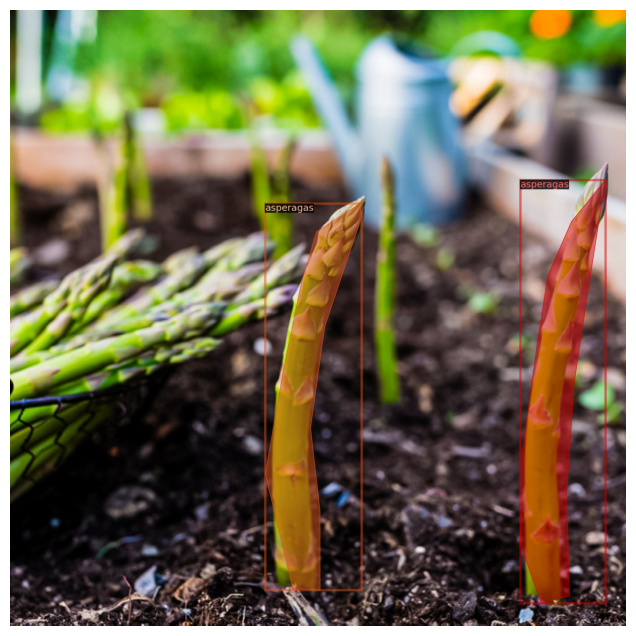

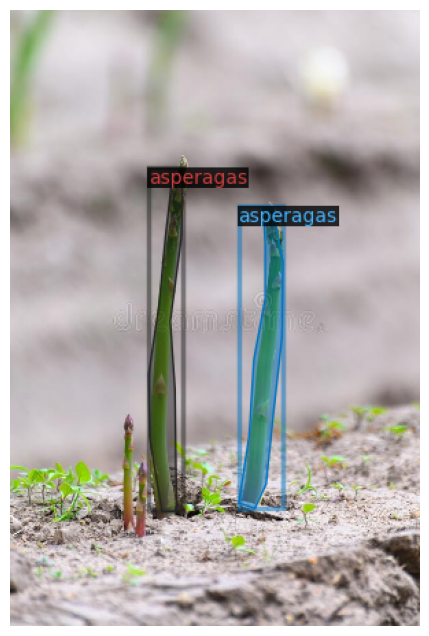

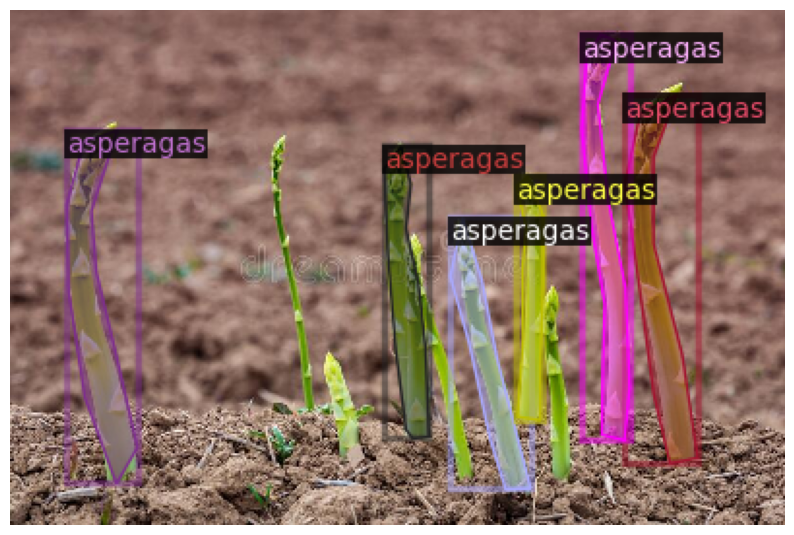

In [6]:
#visualize training data
asparagas_metadata = MetadataCatalog.get("asparagas_train")
dataset_dicts = DatasetCatalog.get("asparagas_train",)

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread( d['file_name'])
    
    # Option 1 (Recommended)
    visualizer = Visualizer(img[:, :, ::-1], metadata=asparagas_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(vis.get_image())  # No conversion needed
    plt.axis('off')
    plt.show()

In [7]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("asparagas_train")
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cuda'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/28 20:07:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/28 20:07:53 d2.engine.train_loop]: Starting training from iteration 0


/home/ghostfish/Downloads/CLOUDPROCESSOR/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/28 20:08:01 d2.utils.events]:  eta: 0:01:34  iter: 19  total_loss: 2.53  loss_cls: 0.6239  loss_box_reg: 0.8718  loss_mask: 0.6975  loss_rpn_cls: 0.1322  loss_rpn_loc: 0.1636    time: 0.3305  last_time: 0.2843  data_time: 0.0161  last_data_time: 0.0032   lr: 1.6068e-05  max_mem: 2154M
[06/28 20:08:07 d2.utils.events]:  eta: 0:01:25  iter: 39  total_loss: 2.25  loss_cls: 0.5573  loss_box_reg: 0.8696  loss_mask: 0.6691  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.1321    time: 0.3275  last_time: 0.3110  data_time: 0.0170  last_data_time: 0.0034   lr: 3.2718e-05  max_mem: 2287M
[06/28 20:08:07 d2.utils.events]:  eta: 0:01:25  iter: 39  total_loss: 2.25  loss_cls: 0.5573  loss_box_reg: 0.8696  loss_mask: 0.6691  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.1321    time: 0.3275  last_time: 0.3110  data_time: 0.0170  last_data_time: 0.0034   lr: 3.2718e-05  max_mem: 2287M
[06/28 20:08:13 d2.utils.events]:  eta: 0:01:15  iter: 59  total_loss: 2.138  loss_cls: 0.4713  loss_box_reg: 0.8998  loss_mask:

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[06/28 20:42:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/ghostfish/Downloads/CLOUDPROCESSOR/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map

In [17]:
predictor.model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

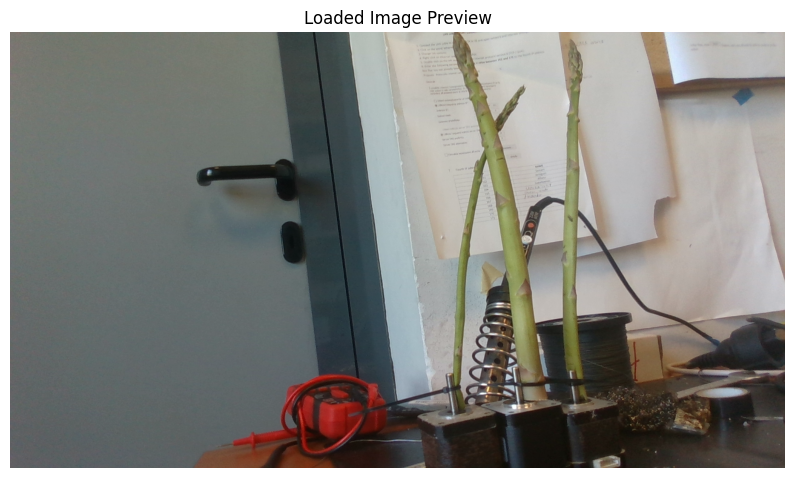

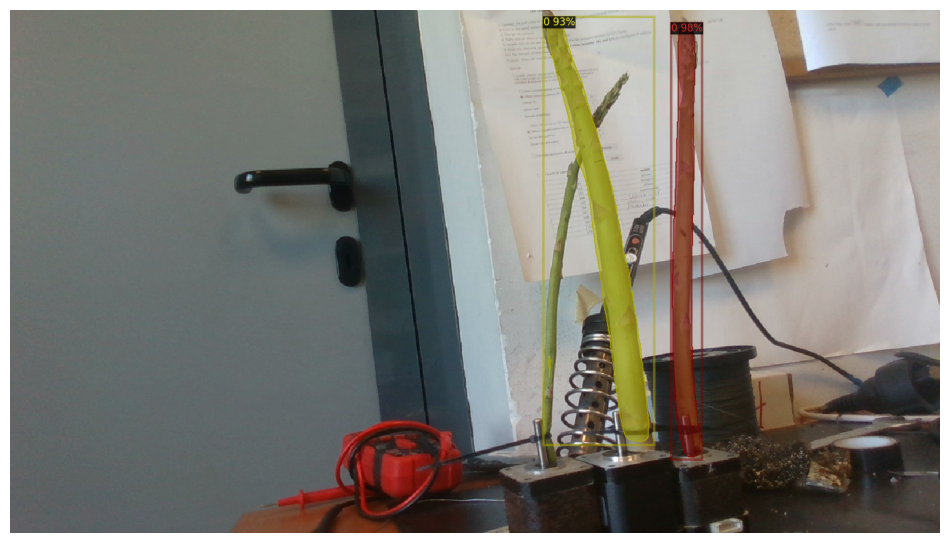

In [12]:
im = cv2.imread("./d435_Color.png")
# Check if image loaded successfully
if im is None:
    print("Error: Could not load image. Please check the file path.")
else:
    # Convert BGR to RGB for matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Proper conversion
    plt.axis('off')  # Hide axes
    plt.title("Loaded Image Preview")
    plt.show()

outputs = predictor(im)

# Visualization - Proper color handling
v = Visualizer(im[:, :, ::-1],  # Convert BGR to RGB here
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display options:

# Option 1: For Jupyter/Colab with matplotlib (recommended)
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())  # Visualizer output is already RGB
plt.axis('off')
plt.show()



Mask saved as 'segmentation_mask.png'
Masked result saved as 'masked_result.jpg'


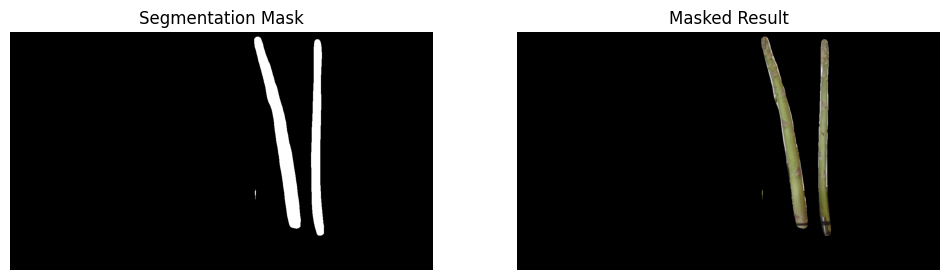

In [13]:
instances = outputs["instances"].to("cpu")

instances = outputs["instances"].to("cpu")

if len(instances) > 0:
    # Create combined mask (PyTorch tensor)
    combined_mask = instances.pred_masks.any(dim=0)  # Logical OR of all masks
    
    # Convert to numpy and scale to 0-255
    final_mask = (combined_mask.numpy() * 255).astype(np.uint8)
    
    # Apply mask to original image
    masked_image = cv2.bitwise_and(im, im, mask=final_mask)
    
    # Save the mask
    cv2.imwrite("segmentation_mask.png", final_mask)
    print("Mask saved as 'segmentation_mask.png'")
    
    # Save masked image (optional)
    cv2.imwrite("masked_result.jpg", cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    print("Masked result saved as 'masked_result.jpg'")
    
    # Visualize
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(final_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Masked Result")
    plt.axis('off')
    plt.show()

else:
    print("No objects detected - no mask created")


In [14]:
!which python
!python --version
!pip show detectron2

/home/ghostfish/Downloads/CLOUDPROCESSOR/bin/python
Python 3.10.12
Python 3.10.12
